In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from PIL import Image
import os
import os.path
import glob
import argparse

In [2]:
#https://stackoverflow.com/questions/12299870/computing-x-y-coordinate-3d-from-image-point
#https://github.com/rodolfoap/OpenCV-2Dto3D/blob/master/transform.cpp
#https://www.elsevier.es/en-revista-journal-applied-research-technology-jart-81-articulo-projector-calibration-for-pattern-projection-S1665642314716086?fbclid=IwAR1wAECeNQMEBO-BF8HaAy1AvMraWlumSZ9NeSsTixzpgZJsH0H5O8mL14g

In [3]:
np.set_printoptions(suppress=True)

# Prepare object points for printed chessboard

In [4]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# (8,6) is for the given testing images.
# If you use the another data (e.g. pictures you take by your smartphone), 
# you need to set the corresponding numbers.
corner_x = 8
corner_y = 7
objp = np.zeros((corner_x*corner_y,3), np.float32)
objp[:,:2] = np.mgrid[0:corner_x, 0:corner_y].T.reshape(-1,2)
block_len = 2.5
objp = objp * block_len

# Prepare projector image points for projected chessboard

Start finding chessboard corners of depth image...
find the chessboard corners of chessboard/02.png


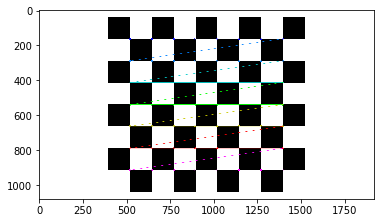

In [5]:
# Arrays to store object points and image points from all the images.
# objpoints = [] # 3d points in real world space
# projected_imgpoints = [] # 2d points in image plane.
chessboard_img_corners = []

pro_img_size = (10, 10)
img_size = (10, 10)

# Make a list of calibration images
images = glob.glob('chessboard/02.png')

# Step through the list and search for chessboard corners
print('Start finding chessboard corners of depth image...')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)
    pro_img_size = (img.shape[1], img.shape[0])

    #Find the chessboard corners
    print('find the chessboard corners of',fname)
    ret, chessboard_img_corners = cv2.findChessboardCorners(gray, (corner_x,corner_y), None)

    # If found, add object points, image points
    if ret == True:
#         projected_imgpoints.append(chessboard_img_corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (corner_x,corner_y), chessboard_img_corners, ret)
        plt.imshow(img)
        


# Known camera intrinsic parameters

In [6]:
RGB_mtx = np.mat([[913.24145912,   0.,         668.9538477  ],
 [  0.,         905.10342204, 389.24919723],
 [  0.,           0.,           1.        ]])

RGB_dist =  np.mat([[ 0.25755514, -0.92817129,  0.00150453,  0.01340316,  1.17293952]])

# Calculate the extrinsic parameters for camera

find the chessboard corners of printed_chessboard\09.png
[[ 8.44313107]
 [11.26667529]
 [44.44298422]]

find the chessboard corners of printed_chessboard\_00.jpg
[[ 5.64265931]
 [ 9.72841088]
 [45.26675821]]

find the chessboard corners of printed_chessboard\_01.jpg
[[ 8.92214224]
 [ 9.68838614]
 [43.93046974]]



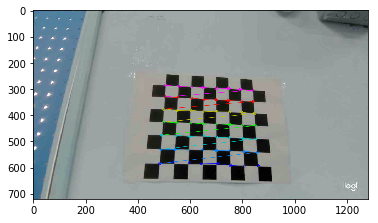

In [7]:
# Calculate the extrinsic parameters using the printed chessboard with the help of the calibrated camera.
T = []
R = []

images = glob.glob('printed_chessboard/*g')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)
    img_size = (img.shape[1], img.shape[0])

    #Find the chessboard corners
    print('find the chessboard corners of',fname)
    ret, printed_corners = cv2.findChessboardCorners(gray, (corner_x,corner_y), None)

    # If found, add object points, image points
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (corner_x,corner_y), printed_corners, ret)
        plt.imshow(img)
        
        retval, rvec, tvec = cv2.solvePnP(objp, printed_corners, RGB_mtx, RGB_dist)
        T.append(tvec)
        R.append(rvec)
        print(tvec)
        print()
#         print(rvec)
        #tvec rvec store into list

# Calculate the corners of the projected chessboard 
# (with camera's intrinsic and extrinsic matrix and its imagepoints)

In [8]:
from numpy.linalg import inv
def calculate_XYZ(u,v, rotationMatrix, translationVector, cameraMatrix):
    #https://github.com/rodolfoap/OpenCV-2Dto3D/blob/master/transform.cpp                                  
    #Solve: From Image Pixels, find World Points
    Z = 0;
    rotationMatrix,_ = cv2.Rodrigues(rotationMatrix)
    
    uv_1 = np.array([[u,v,1]], dtype=np.float32)
    uv_1 = uv_1.T
    
    invM_x_uv1 = np.matmul(inv(cameraMatrix),uv_1)
    invR_x_invM_x_uv1 = np.matmul(inv(rotationMatrix), invM_x_uv1)
    invR_x_tvec = np.matmul(inv(rotationMatrix), translationVector)
    
    s = (Z + invR_x_tvec[2]) / invR_x_invM_x_uv1[2]
#     print(s,invR_x_invM_x_uv1,invR_x_tvec)
    wcPoint =  s[0,0] * invR_x_invM_x_uv1 - invR_x_tvec

#     print(wcPoint)

    return np.float32(wcPoint.T[0])

In [9]:
# #Test the function (u,v ==> x,y,z=0)
# # print(projected_corners)
# p = calculate_XYZ(printed_corners[0,0,0],printed_corners[0,0,1], R[0], T[0], RGB_mtx)
# print(p)
# # print(objp)

find the chessboard corners of projected_chessboard\08.png
[[ 4.268617   2.2107966  0.       ]
 [ 6.636193   2.1568882  0.       ]
 [ 8.945078   1.9277455  0.       ]
 [11.235421   1.78234    0.       ]
 [13.487096   1.7200104  0.       ]
 [15.730703   1.4540098  0.       ]
 [17.958094   1.288862   0.       ]
 [20.141972   1.1101345  0.       ]
 [ 4.23641    4.7523704  0.       ]
 [ 6.6106043  4.5607157  0.       ]
 [ 9.000525   4.3902974  0.       ]
 [11.297777   4.256602   0.       ]
 [13.647001   4.036171   0.       ]
 [15.867749   3.873097   0.       ]
 [18.13715    3.6311402  0.       ]
 [20.347284   3.4371994  0.       ]
 [ 4.161905   7.2562532  0.       ]
 [ 6.6237173  7.0865664  0.       ]
 [ 9.003055   6.8699455  0.       ]
 [11.380516   6.6408553  0.       ]
 [13.70907    6.458068   0.       ]
 [16.027445   6.215655   0.       ]
 [18.297728   6.0281177  0.       ]
 [20.623491   5.817442   0.       ]
 [ 4.131059   9.827737   0.       ]
 [ 6.6086082  9.578615   0.       ]
 [ 9.

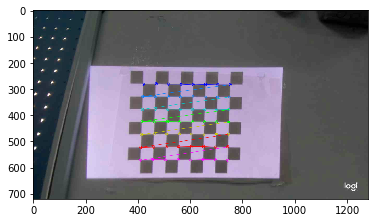

In [10]:
#Calculate the corners of the projected chessboard 
#with the help of the extrinsic and intrinsic parameters of the camera 
#and store in the ‘object points’ matrix.
projected_objpoints = []
projected_imgpoints = []
camera_imgpoints = [] 

# RGB_projected_imgpoints = [] # 2d points in image plane.

projected_obj = np.zeros((56,3), dtype=np.float32)

imgs = glob.glob('projected_chessboard/*g')
for idx, fname in enumerate(imgs):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)
    img_size = (img.shape[1], img.shape[0])

    #Find the chessboard corners
    print('find the chessboard corners of',fname)
    #projected_corners in RGB image space
    ret, projected_corners = cv2.findChessboardCorners(gray, (corner_x,corner_y), None)

    # If found, add object points, image points
    if ret == True:
        projected_obj = np.zeros((56,3), dtype=np.float32)
        #projected points in RGB image space to would coord
        for i in range(56):
            #對應點找反==>反過來放 55-i 
            projected_obj[55-i,:] = calculate_XYZ(projected_corners[i,0,0], projected_corners[i,0,1], R[idx], T[idx], RGB_mtx)
            

        print(projected_obj)
        projected_objpoints.append(projected_obj)
        
        projected_imgpoints.append(chessboard_img_corners)
        camera_imgpoints.append(projected_corners)
        
#         print(chessboard_img_corners)
#         print(projected_corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (corner_x,corner_y), projected_corners, ret)
        plt.imshow(img)

# print(projected_objpoints)

# Calibration projector

In [11]:
print(len(projected_objpoints), len(projected_imgpoints))
print(pro_img_size)

ret, projector_mtx, projector_dist, projector_rvecs, projector_tvecs = cv2.calibrateCamera(projected_objpoints, projected_imgpoints, pro_img_size,None,None)
projector_Vr = np.array(projector_rvecs)
projector_Tr = np.array(projector_tvecs)
projector_extrinsics = np.concatenate((projector_Vr, projector_Tr), axis=1).reshape(-1,6)

print(ret)
print(projector_mtx)
print(projector_dist)
print()
print(projector_extrinsics)
print(projector_Tr)

# print(projected_objpoints)

3 3
(1920, 1080)
2.28557918456714
[[2632.88528666    0.          753.71811534]
 [   0.         2633.13459721  611.01408057]
 [   0.            0.            1.        ]]
[[ -0.64789326   5.69455107   0.02388628  -0.00882401 -18.6186877 ]]

[[  0.40378779   0.19744773   0.05277386  -8.41850472 -10.78157368
   47.54944062]
 [  0.34642173   0.29947002  -0.0133607   -6.36244319  -8.0170371
   48.59809781]
 [  0.39678053   0.15267497   0.00825952  -9.52232738  -8.9429594
   46.68426082]]
[[[ -8.41850472]
  [-10.78157368]
  [ 47.54944062]]

 [[ -6.36244319]
  [ -8.0170371 ]
  [ 48.59809781]]

 [[ -9.52232738]
  [ -8.9429594 ]
  [ 46.68426082]]]


# get the last one pair to compute the relationship between camera and projector

In [12]:
#get the last one pair
_projected_objpoints = []
_camera_imgpoints = []
_projected_imgpoints = []

_projected_objpoints.append(projected_objpoints[-1])
_camera_imgpoints.append(camera_imgpoints[-1])
_projected_imgpoints.append(projected_imgpoints[-1])

In [13]:
print('=== Result ===')
ret, depth_cam_int, depth_cam_dist, RGB_cam_int, RGB_cam_dist, depth_rgb_rmat, depth_rgb_tvec, E, F = cv2.stereoCalibrate(
    _projected_objpoints, _camera_imgpoints, _projected_imgpoints, RGB_mtx, RGB_dist, projector_mtx, projector_dist, None)

print('  RMS :', ret)
print('  RGB Camera intrinsic parameters :')
print(depth_cam_int, '    ')
print('  RGB Camera distortion parameters :')
print(depth_cam_dist, '    ')
print()
print('  Projector intrinsic parameters :')
print(RGB_cam_int, '    ')
print('  Projector distortion parameters :')
print(RGB_cam_dist, '    ')
print()
print('  Rotation matrix / translation vector from RGB camera to Projector')
print('  (they translate points from RGB camera coord to Projector coord) :')
print(depth_rgb_rmat, '    ')
print(depth_rgb_tvec, '    ')
print()
print('Rotation vector')
v,_ = cv2.Rodrigues(depth_rgb_rmat)
print(v)

=== Result ===
  RMS : 1.9233062209225504
  RGB Camera intrinsic parameters :
[[913.24145912   0.         668.9538477 ]
 [  0.         905.10342204 389.24919723]
 [  0.           0.           1.        ]]     
  RGB Camera distortion parameters :
[[ 0.25755514 -0.92817129  0.00150453  0.01340316  1.17293952]]     

  Projector intrinsic parameters :
[[2632.88528666    0.          753.71811534]
 [   0.         2633.13459721  611.01408057]
 [   0.            0.            1.        ]]     
  Projector distortion parameters :
[[ -0.64789326   5.69455107   0.02388628  -0.00882401 -18.6186877 ]]     

  Rotation matrix / translation vector from RGB camera to Projector
  (they translate points from RGB camera coord to Projector coord) :
[[ 0.98172404  0.0298862   0.18794871]
 [-0.0053981   0.99156793 -0.12947548]
 [-0.19023345  0.12609463  0.97360741]]     
[[-0.63573642]
 [ 2.70586635]
 [ 2.7919342 ]]     

Rotation vector
[[ 0.12892811]
 [ 0.19078253]
 [-0.01779997]]


In [14]:
# Result
# Projector intrinsic parameters :
# [[2632.88528666    0.          753.71811534]
#  [   0.         2633.13459721  611.01408057]
#  [   0.            0.            1.        ]]     
#   Projector distortion parameters :
# [[ -0.64789326   5.69455107   0.02388628  -0.00882401 -18.6186877 ]]  

# Rotation matrix / translation vector from RGB camera to Projector
#   (they translate points from RGB camera coord to Projector coord) :
# [[ 0.98172404  0.0298862   0.18794871]
#  [-0.0053981   0.99156793 -0.12947548]
#  [-0.19023345  0.12609463  0.97360741]]   

# [[-0.63573642]
#  [ 2.70586635]
#  [ 2.7919342 ]] 

# Rotation vector
# [[ 0.12892811]
#  [ 0.19078253]
#  [-0.01779997]]


In [15]:
import camera_calibration_show_extrinsics as show

Show the camera extrinsics


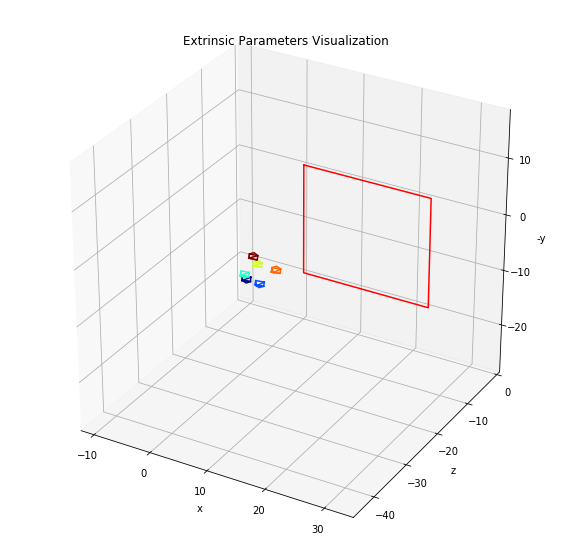

In [16]:
# show the camera extrinsics
print('Show the camera extrinsics')
camera_extrinsics = np.concatenate((R, T), axis=1).reshape(-1,6)
# plot setting
# You can modify it for better visualization
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# camera setting
camera_matrix = RGB_mtx
cam_width = 0.064/0.1
cam_height = 0.032/0.1
scale_focal = 1600
# chess board setting
board_width = 9
board_height = 8
square_size = 2.5

Allextrinsics = np.zeros((camera_extrinsics.shape[0]+projector_extrinsics.shape[0],6))
Allextrinsics[:camera_extrinsics.shape[0]] = camera_extrinsics
Allextrinsics[camera_extrinsics.shape[0]:] = projector_extrinsics

# display
# True -> fix board, moving cameras
# False -> fix camera, moving boards
min_values, max_values = show.draw_camera_boards(ax, camera_matrix, cam_width, cam_height,
                                                scale_focal, Allextrinsics, board_width,
                                                board_height, square_size, True)

# _min_values, _max_values = show.draw_camera_boards(ax, RGB_cam_int, cam_width, cam_height,
#                                                 scale_focal, RGB_extrinsics, board_width,
#                                                 board_height, square_size, True)

X_min = min_values[0]
X_max = max_values[0]
Y_min = min_values[1]
Y_max = max_values[1]
Z_min = min_values[2]
Z_max = max_values[2]
max_range = np.array([X_max-X_min, Y_max-Y_min, Z_max-Z_min]).max() / 2.0

mid_x = (X_max+X_min) * 0.5
mid_y = (Y_max+Y_min) * 0.5
mid_z = (Z_max+Z_min) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, 0)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('-y')
ax.set_title('Extrinsic Parameters Visualization')
plt.show()